## Librerias

In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.pipeline import make_pipeline


## Importacion Dataset

In [ ]:
# Descargar la última versión del dataset
path = kagglehub.dataset_download("fedesoriano/spanish-wine-quality-dataset")

# Cargar el archivo CSV en un DataFrame
file_path = f"{path}/wines_SPA.csv"  # Ajusta el nombre del archivo si es diferente
data = pd.read_csv(file_path)

# Mostrar las columnas del dataset
print("Columnas del dataset:", data.columns.tolist())


Columnas del dataset: ['winery', 'wine', 'year', 'rating', 'num_reviews', 'country', 'region', 'price', 'type', 'body', 'acidity']


## Preprocesamiento

In [ ]:
# 2. Procesamiento de datos
# Comprobar valores nulos
data.isnull().sum()

# Escalar datos (excepto las columnas categóricas como 'winery', 'wine', 'country', 'region', 'type')
scaler = StandardScaler()
X = data.drop(columns=['rating', 'winery', 'wine', 'country', 'region', 'type', 'year'])
X_scaled = scaler.fit_transform(X)
y = data['rating']

## Matriz de correlacion

Matriz de correlación:
               rating  num_reviews     price      body   acidity
rating       1.000000     0.015229  0.544809  0.163033 -0.094553
num_reviews  0.015229     1.000000 -0.030083  0.067106  0.040138
price        0.544809    -0.030083  1.000000  0.153624 -0.032870
body         0.163033     0.067106  0.153624  1.000000 -0.017950
acidity     -0.094553     0.040138 -0.032870 -0.017950  1.000000


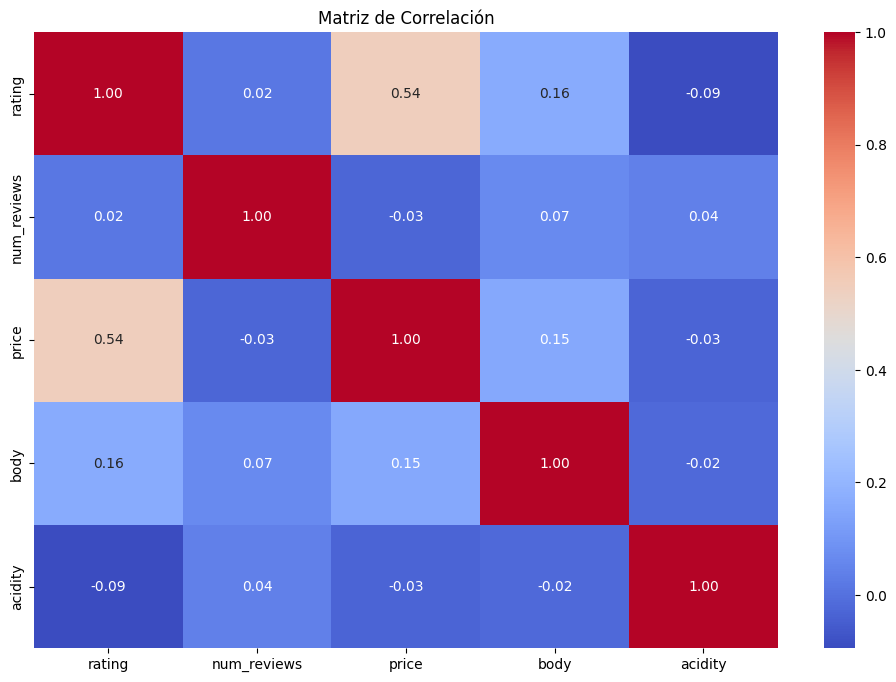

In [ ]:
# Seleccionar solo las columnas numéricas
numerical_data = data.select_dtypes(include=['float64', 'int64'])

# Calcular la matriz de correlación
correlation_matrix = numerical_data.corr()

# Mostrar la matriz de correlación
print("Matriz de correlación:")
print(correlation_matrix)

# Visualizar la matriz de correlación con un heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matriz de Correlación")
plt.show()


## Matriz de dispersión

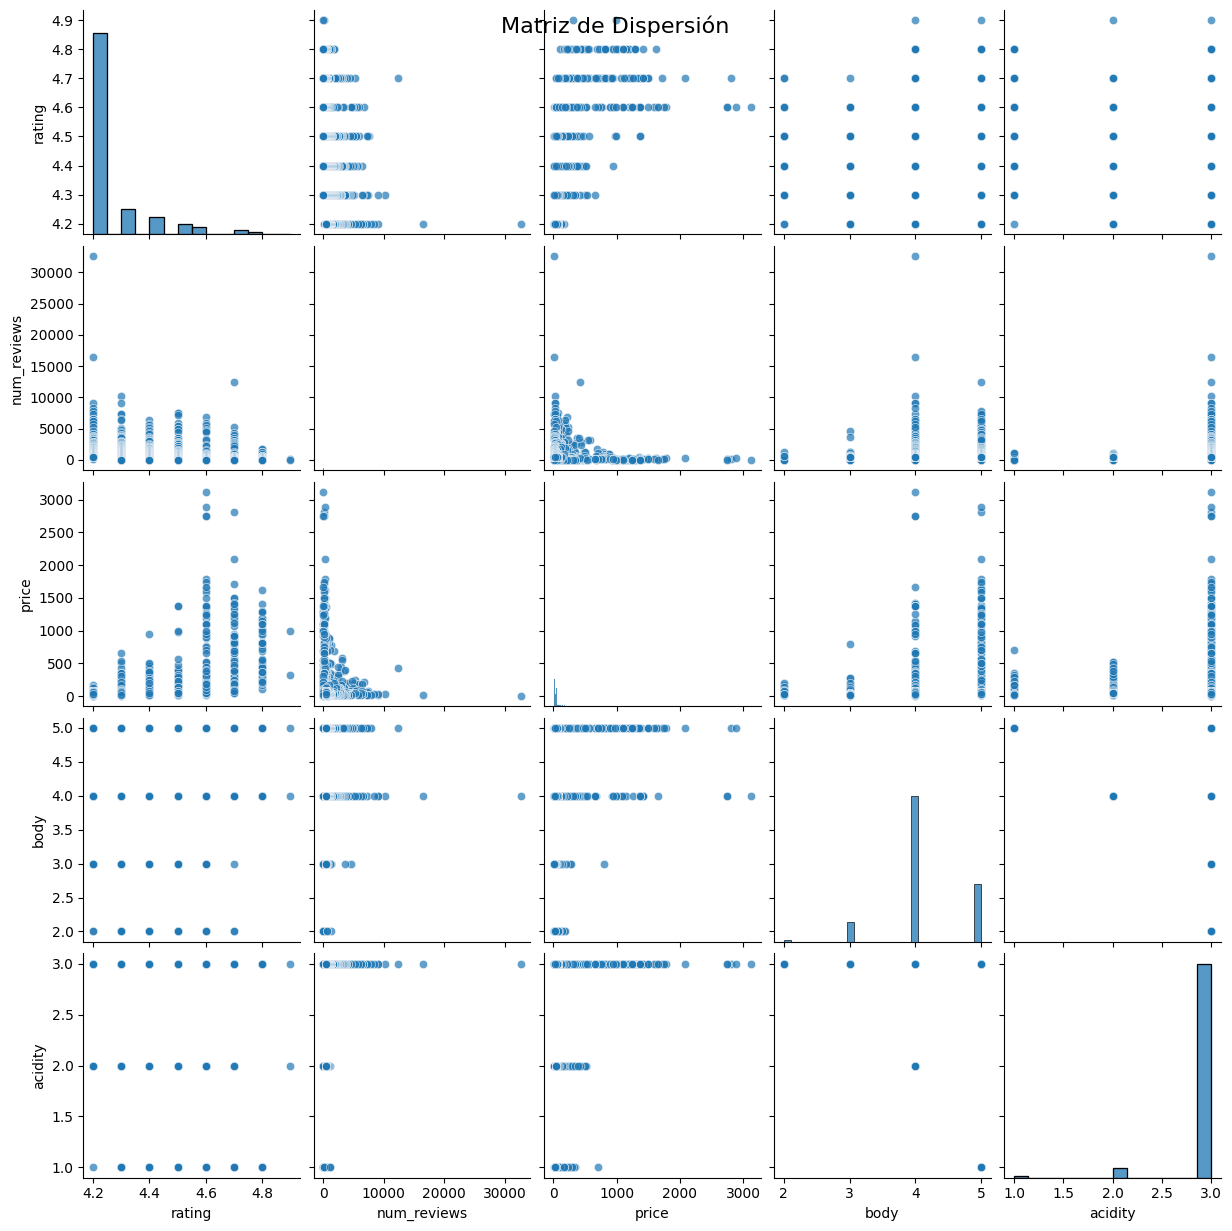

In [ ]:
# Seleccionar solo las columnas numéricas
numerical_data = data.select_dtypes(include=['float64', 'int64'])

# Crear la matriz de dispersión (pairplot)
sns.pairplot(numerical_data, plot_kws={'alpha': 0.7})

# Mostrar el gráfico
plt.suptitle('Matriz de Dispersión', size=16)
plt.show()


## SelectKBest.

In [ ]:
# Seleccionar solo las columnas numéricas
numerical_data = data.select_dtypes(include=['float64', 'int64'])

# Rellenar los valores nulos con la media de cada columna
numerical_data = numerical_data.fillna(numerical_data.mean())

# Definir las características (X) y la variable objetivo (y)
X = numerical_data
y = data['rating']

# Aplicar SelectKBest con el estadístico f_classif
select_k_best = SelectKBest(score_func=f_classif, k=2)  # Ajusta 'k' según tus necesidades
X_new = select_k_best.fit_transform(X, y)

# Obtener las características seleccionadas
selected_features = X.columns[select_k_best.get_support()]

# Mostrar las mejores características
print(f"Las mejores {select_k_best.k} características son: {selected_features}")


Las mejores 2 características son: Index(['price', 'body'], dtype='object')


## Explicacion de entrenamiento

Al tratarse de un modelo de tipo Categorical y Gaussian el entrenamiento por Epoch no es necesario ya que utilizan los mismos datoas para predecir de forma matematica

## Sin CrossValidation

In [ ]:
# Convertir 'rating' en categorías (por ejemplo, baja, media, alta)
bins = [0, 5, 6, 10]  # Definir los rangos de calificación
labels = ['baja', 'media', 'alta']  # Etiquetas de las categorías


# Selección de las 2 mejores características
select_k_best = SelectKBest(score_func=f_classif, k=2)  # Selección de características
X_new = select_k_best.fit_transform(X, y)  # Transformación de los datos
selected_features = X.columns[select_k_best.get_support()]
print(f"Las mejores características seleccionadas son: {selected_features.tolist()}")

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenar el modelo Naive Bayes
model = GaussianNB()
model.fit(X_train_scaled, y_train)

# Realizar predicciones
y_pred = model.predict(X_test_scaled)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy:.4f}")

# Imprimir el reporte de clasificación
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))

# Importancia de características
importances = model.theta_  # Los valores de las medias para cada clase
for name, importance in zip(selected_features, importances[0]):
    print(f"Característica: {name}, Media: {importance:.4f}")

Las mejores características seleccionadas son: ['price', 'body']
Precisión del modelo: 0.7993

Reporte de clasificación:
               precision    recall  f1-score   support

        Alto       0.85      0.37      0.51       144
        Bajo       0.82      1.00      0.90      1106
       Medio       0.48      0.17      0.25       250

    accuracy                           0.80      1500
   macro avg       0.72      0.51      0.55      1500
weighted avg       0.76      0.80      0.75      1500

Característica: price, Media: 1.6574
Característica: body, Media: 0.5132


## Con Crossvalidation

In [ ]:
# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_new)

# Entrenar el modelo Naive Bayes
model = GaussianNB()

# Validación cruzada: 5 pliegues (folds)
cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='accuracy')

# Mostrar los resultados de la validación cruzada
print(f"Precisión por pliegue: {cv_scores}")
print(f"Precisión media de la validación cruzada: {cv_scores.mean():.4f}")

# Ajustar el modelo con todos los datos y evaluar con clasificación final
model.fit(X_scaled, y)
y_pred = model.predict(X_scaled)

# Reporte de clasificación final
print("\nReporte de clasificación:\n", classification_report(y, y_pred))

# Importancia de características (Media para cada clase)
importances = model.theta_  # Los valores de las medias para cada clase
for name, importance in zip(selected_features, importances[0]):
    print(f"Característica: {name}, Media: {importance:.4f}")


Precisión por pliegue: [0.84866667 0.83266667 0.802      0.79533333 0.792     ]
Precisión media de la validación cruzada: 0.8141

Reporte de clasificación:
               precision    recall  f1-score   support

        Alto       0.84      0.34      0.48       630
        Bajo       0.84      1.00      0.91      5679
       Medio       0.49      0.19      0.28      1191

    accuracy                           0.82      7500
   macro avg       0.72      0.51      0.56      7500
weighted avg       0.78      0.82      0.77      7500

Característica: price, Media: 1.6332
Característica: body, Media: 0.5244


## Prediccion en funcion del precio y cuerpo

In [ ]:
# Aquí puedes poner las características de un vino específico para predecir su clase
vino_ejemplo = np.array([[89.9, 4.0]])  # Ejemplo: [price, body]

# Convertir vino_ejemplo en un DataFrame con las mismas columnas que las seleccionadas
vino_ejemplo_df = pd.DataFrame(vino_ejemplo, columns=selected_features)

# Aplicar la selección de características a los datos de entrada del ejemplo
vino_ejemplo_selected = select_k_best.transform(vino_ejemplo_df)

# Escalar las características del ejemplo usando el mismo escalador que para el entrenamiento
vino_ejemplo_scaled = scaler.transform(vino_ejemplo_selected)

# Realizar la predicción con el modelo entrenado
prediccion = model.predict(vino_ejemplo_scaled)

# Mostrar el resultado de la predicción
print(f"La predicción para el vino con características {vino_ejemplo[0]} es: {prediccion[0]}")

La predicción para el vino con características [89.9  4. ] es: Medio
